# PreProcessing


In [ ]:
#importing libraries and functions
import tensorflow as tf
from tensorflow.keras.layers import Input, Reshape, Dropout, Dense 
from tensorflow.keras.layers import Flatten, BatchNormalization
from tensorflow.keras.layers import Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow import keras
import numpy as np
from PIL import Image
from tqdm import tqdm
import os 
import time
import matplotlib.pyplot as plt

In [ ]:
#unzipping dataset
!unzip "__" ->#link of compressed dataset

In [ ]:
#resolution of images
GENERATE_SQUARE = 96 #96x96
IMAGE_CHANNELS = 3  #RGB

# Preview images for viewing samples during training
PREVIEW_ROWS = 4
PREVIEW_COLS = 7
PREVIEW_MARGIN = 16

# Size vector to generate images from (noise vector)
SEED_SIZE = 100  

# Configuration
DATA_PATH = '/content/cropped aloa lectinea'
EPOCHS = 2000
BATCH_SIZE = 32
BUFFER_SIZE = 600

print(f"Will generate {GENERATE_SQUARE}px square images.")

Will generate 96px square images.


In [ ]:
#converting of (255,255) pixel value to (-1, 1) as of generator's last layer's activation Tanh range

training_binary_path = os.path.join(DATA_PATH,
        f'training_data_{GENERATE_SQUARE}_{GENERATE_SQUARE}.npy')


print(f"Looking for file: {training_binary_path}")

if not os.path.isfile(training_binary_path):
  print("Loading training images...")

  training_data = []
  faces_path = DATA_PATH
  for filename in tqdm(os.listdir(faces_path)):
      path = os.path.join(faces_path,filename)
      image = Image.open(path).resize((GENERATE_SQUARE,GENERATE_SQUARE),Image.ANTIALIAS)
      training_data.append(np.asarray(image))
  training_data = np.reshape(training_data,(-1,GENERATE_SQUARE,GENERATE_SQUARE,IMAGE_CHANNELS))
  training_data = training_data.astype(np.float32)
  training_data = training_data / 127.5 - 1.


  print("Saving training image binary...")
  np.save(training_binary_path,training_data)
else:
  print("Loading previous training pickle...")
  training_data = np.load(training_binary_path)

In [ ]:
#making batches of data
train_dataset = tf.data.Dataset.from_tensor_slices(training_data).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# GAN

In [ ]:
#generator network
generator = keras.models.Sequential([
    keras.layers.Dense(6*6, input_shape=[SEED_SIZE]),
    keras.layers.Dense(6*6*256),
    keras.layers.Reshape([6, 6, 256]),
    keras.layers.Conv2DTranspose(64, (5,5), (2,2), padding="same"),
    keras.layers.LeakyReLU(0.2),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(32, (5,5), (2,2), padding="same"),
    keras.layers.LeakyReLU(0.2),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(16, (5,5), (2,2), padding="same"),
    keras.layers.LeakyReLU(0.2),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(3, (5,5), (2,2), padding="same", activation="tanh"),
])

In [ ]:
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 36)                3636      
_________________________________________________________________
dense_1 (Dense)              (None, 9216)              340992    
_________________________________________________________________
reshape (Reshape)            (None, 6, 6, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 12, 12, 64)        409664    
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 12, 12, 64)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 12, 12, 64)        256       
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 24, 24, 32)        5

In [ ]:
#discriminator network
discriminator = keras.models.Sequential([
    keras.layers.Conv2D(32, (5,5), (2,2), padding="same", input_shape=[96, 96, 3]),
    keras.layers.LeakyReLU(0.2),
    keras.layers.Dropout(0.3),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(64, (5,5), (2,2), padding="same"),
    keras.layers.LeakyReLU(0.2),
    keras.layers.Dropout(0.3),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(64, (5,5), (2,2), padding="same"),
    keras.layers.LeakyReLU(0.2),
    keras.layers.Dropout(0.3),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(128, (5,5), (2,2), padding="same"),
    keras.layers.LeakyReLU(0.2),
    keras.layers.Dropout(0.3),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 32)        2432      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 48, 48, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 48, 48, 32)        0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 48, 48, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 64)        51264     
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 24, 24, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 24, 24, 64)       

# Saving images

In [ ]:
OUT_PATH='/content/output'

In [ ]:
def save_images(cnt,noise):
  image_array = np.full(( 
      PREVIEW_MARGIN + (PREVIEW_ROWS * (GENERATE_SQUARE+PREVIEW_MARGIN)), 
      PREVIEW_MARGIN + (PREVIEW_COLS * (GENERATE_SQUARE+PREVIEW_MARGIN)), 3), 
      255, dtype=np.uint8)
  
  generated_images = generator.predict(noise)

  generated_images = 0.5 * generated_images + 0.5

  image_count = 0
  for row in range(PREVIEW_ROWS):
      for col in range(PREVIEW_COLS):
        r = row * (GENERATE_SQUARE+16) + PREVIEW_MARGIN
        c = col * (GENERATE_SQUARE+16) + PREVIEW_MARGIN
        image_array[r:r+GENERATE_SQUARE,c:c+GENERATE_SQUARE] = generated_images[image_count] * 255
        image_count += 1

          
  output_path = os.path.join(OUT_PATH,f"output-{cnt}")
  if not os.path.exists(output_path):
    os.makedirs(output_path)
  
  filename = os.path.join(output_path,f"train-{cnt}.png")
  im = Image.fromarray(image_array)
  im.save(filename)
  generator.save(os.path.join(output_path,f"face_generator-{cnt}.h5"))

# Testing networks

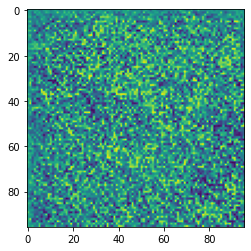

In [ ]:
#generating random sample before training
noise = tf.random.normal([1, SEED_SIZE])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0])

In [ ]:
image_shape = (GENERATE_SQUARE,GENERATE_SQUARE,IMAGE_CHANNELS)
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.16560863]], shape=(1, 1), dtype=float32)


# Compiling Gan

In [ ]:
#defining losses
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)


def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
#defining otptimizer
generator_optimizer = tf.keras.optimizers.Adam(1.5e-4,0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(1.5e-4,0.5)

# Training the Gan


In [ ]:
@tf.function
def train_step(images):
  seed = tf.random.normal([BATCH_SIZE, SEED_SIZE])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(seed, training=True)

    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)
    

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)#calculating gradients of generator
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)#calculating gradients of discriminator

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))#applying gradients with the optimizer
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))#applying gradients with the optimizer
  return gen_loss,disc_loss

In [ ]:
def train(dataset, epochs):
  fixed_seed = np.random.normal(0, 1, (PREVIEW_ROWS * PREVIEW_COLS, SEED_SIZE))

  for epoch in tqdm(range(epochs)):


    gen_loss_list = []
    disc_loss_list = []

    for image_batch in dataset:
      t = train_step(image_batch)
      gen_loss_list.append(t[0])
      disc_loss_list.append(t[1])

    g_loss = sum(gen_loss_list) / len(gen_loss_list)
    d_loss = sum(disc_loss_list) / len(disc_loss_list)


    print (f'Epoch {epoch+1}, gen loss={g_loss},disc loss={d_loss}')
    if epoch%100==0:
      save_images(epoch,fixed_seed)


  print (f'Training time: {hms_string(epoch_elapsed)}')

In [ ]:
train(train_dataset, EPOCHS)

# Generating images

In [ ]:
from keras.models import load_model

In [ ]:
#loading best model
generator = keras.models.load_model('/content/drive/My Drive/output3/output-1700/face_generator-1700.h5')

In [ ]:
noise = tf.random.normal([1, SEED_SIZE])
generated_image = generator(noise, training=False)
generated_image = 0.5 * generated_image + 0.5
plt.imshow(generated_image[0, :, :, :])

In [ ]:
OUT_PATH_samples='/content/result1'

In [ ]:
output_samples_path = os.path.join(OUT_PATH_samples,f"results")

In [ ]:
import numpy as np


In [ ]:
x=100 # no of samples to be generated
for i in range(x):
  if not os.path.exists(output_path):
      os.makedirs(output_path)
  noise = tf.random.normal([1, SEED_SIZE])
  generated_image = generator(noise, training=False)
  generated_image = 0.5 * generated_image + 0.5
  generated_image=generated_image[0, :, :, :]
  filename = os.path.join(output_samples_path,f"aloa_lectinea_generated-{i}.png")
  generated_image=np.asarray(generated_image)
  im = Image.fromarray((generated_image * 255).astype(np.uint8))
  im.save(filename)


# moving

In [ ]:
!mv '/content/result1/results' '/content/drive/My Drive'